<h1><center>Representaciones Inmersas (word-embeddings) Utilizando Distintos Modelos</center></h1> 

In [20]:
# Cálculo numérico y gestión de datos
import numpy as np
import pandas as pd

# Módulos SMS
import sms

# Módulos para procesamiento de texto
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Módulos para deep learning
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense, Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.regularizers import l1,l2,l1_l2

%matplotlib inline

# Visualización de la Base de Datos

  clase  numero
0   ds0   577.0
1   ds1   335.0
2   ds2   473.0
3   ds3   540.0
4   ds4  1061.0
5   ds5  2624.0
6   dp0  2671.0
7   dp1  2939.0


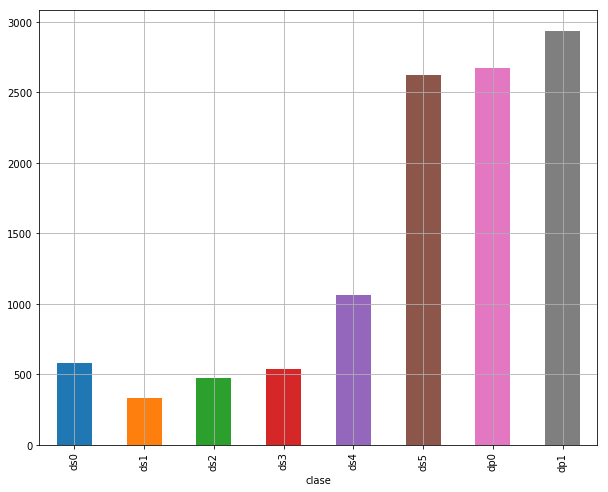

In [21]:
data,dt=sms.view_data()

# Carga datos de entrenamiento y prueba

In [22]:
(x_train,y_train),(x_test,y_test),p_train,edf=sms.load_data(lematize=True,lem='FILE')

Se cargó el archivo en lemas.DataFrame con 11361 lemas
Conjunto de entrenamiento con 3550 instancias.
Conjunto de prueba con 1522 instancias.


## edf (Embeddings Data Frame) contiene el diccionario de palabras y word-embeddings:
 * KRS: Keras embeddings
 * W2V: Word2Vec embeddings
 * FST: FastText embeddings
 
<h2><center><font color='red'>Es aqui donde hay que guardar cada vector (embedding) de cada palabra</font></center></h2> 

In [23]:
#edf #data frame donde hay que guardar los embeddings
edf

,Palabra,Lema,KRS,W2V,FST
0,emocional,emocional,0,0,0
1,sumamente,sumamente,0,0,0
2,inestable,inestable,0,0,0
3,debido,debido,0,0,0
4,estrés,estreì�s,0,0,0
5,supone,suponer,0,0,0
6,falta,falta,0,0,0
7,contacto,contacto,0,0,0
8,hijos,hijo,0,0,0
9,impotencia,impotencia,0,0,0


## Verificación de algunos datos

In [24]:
print('Shape de x_train:')
print(x_train.shape,'\n')

print('x_train[0]:')
print(x_train[0],'\n')
print('y_train[0]:')
print(y_train[0],'\n')
print('x_test[0]:')
print(x_test[0],'\n')
print('y_test[0]:')
print(y_test[0])

Shape de x_train:
(3550,) 

x_train[0]:
igual siempre igual cambia 

y_train[0]:
[1. 0. 0. 0. 0. 0. 0. 1.] 

x_test[0]:
tranquilo salud cambios 

y_test[0]:
[0. 0. 0. 0. 1. 0. 0. 1.]


# Modelo KRS

In [25]:
# Parametrización y arquitectura del modelo KRS
# Entradas:
#  * Datos de entrenamiento: frases de texto
#  * Datos de prueba
#  * Proporción del vocabulario a utilizar
#  * maxima longitud de frases (bool)
# Salidas:
#  * Datos de entrenamiento y prueba como matrices de números enteros
#  * Tokenizador
#  * Tamaño del vocabulario
#  * Longitud de la secuencia numérica (frase)
def keras_embedding(x_train,x_test,voc_prop=1,maxl=True):
    # set vocabulary size
    train_vocab_size = len(set(word_tokenize(" ".join(x_train))))
    vocab_size = int(voc_prop*train_vocab_size)
    print(f"Hay {train_vocab_size} palabras únicas en todo el set de entrenamiento.")
    print(f"Conservando {voc_prop*100}% ({vocab_size}) como tamaño del vocabulario.")

    #tokenize train_ and test_ texts and compute integer codes per word
    tok = Tokenizer(num_words=vocab_size)
    tok.fit_on_texts(x_train)
    X_train = tok.texts_to_sequences(x_train)
    X_test = tok.texts_to_sequences(x_test)
    # Zero padding
    lengths = np.array([len(x) for x in X_train])

    # Sentence size (input)
    if not maxl:
        seque_leng = int(lengths.mean() + 2 * lengths.std())
        mt = "(mu + 2*sigma)"
    else:
        seque_leng = max(lengths)
        mt = "(max length)"
    print(f"Longitud de las frases = {seque_leng} palabras {mt}.")

    X_train = sequence.pad_sequences(X_train, maxlen=seque_leng, padding='pre')
    X_test = sequence.pad_sequences(X_test, maxlen=seque_leng, padding='pre')

    return X_train, X_test,tok,vocab_size,seque_leng

## Visualiza los códigos para X_train[0] <font color='red'>OJO! X_train != x_train</font>

In [26]:
# X_train != x_train
# X_train solo se usa para el modelo KRS
X_train,X_test,tokenizer,vs,sl = keras_embedding(x_train,x_test,voc_prop=1)
print('\nShape de X_train:')
print(X_train.shape,'\n')

print('\n X_train[0]:=\n',X_train[0],'\n')
word_dict=tokenizer.word_index
#Check codes
for code in X_train[0]:
    if code != 0:
        print(list(word_dict.keys())[list(word_dict.values()).index(code)],':',code,',',end=' ')

Hay 10289 palabras únicas en todo el set de entrenamiento.
Conservando 100% (10289) como tamaño del vocabulario.
Longitud de las frases = 77 palabras (max length).

Shape de X_train:
(3550, 77) 


 X_train[0]:=
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  62  49  62 548] 

igual : 62 , siempre : 49 , igual : 62 , cambia : 548 , 

# Arquitectura KRS <font color='red'>(correr antes de un nuevo entrenamiento)</font>

In [27]:
# Size of word embeddings
vec_dim=100

# KRS Model vs y sl calculados arriba
KRS = Sequential()
KRS.add(Embedding(input_dim=vs, output_dim=vec_dim, input_length=sl))
KRS.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# Param = embedding_vect_len * kernel_size * #filters + #filters = 3104
KRS.add(MaxPooling1D(pool_size=2))
KRS.add(LSTM(units=32, dropout=0.25, recurrent_dropout=0.25))
KRS.add(Dense(units=8, activation='sigmoid'))
#KRS.add(Dense(units=8,kernel_regularizer=l2(5E-3), activation='sigmoid'))

# compile network
KRS.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(KRS.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 77, 100)           1028900   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 77, 32)            9632      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 1,047,116
Trainable params: 1,047,116
Non-trainable params: 0
_________________________________________________________________
None


# Entrenamiento del modelo KRS
<p>
<font color='red'>El modelo se guarda en un archivo que se puede recuperar para extraer los embeddings</font>
</p>

In [29]:
# Train the model
from keras.callbacks import EarlyStopping,ModelCheckpoint

filepath="KRS_weights_best_3rd.hdf5" #último archivo guardado
epocas=500
paciencia=20
batch=4

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=paciencia, mode='auto') 
callbacks_list = [checkpoint, early_stop]

KRS.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch, verbose=2, epochs=epocas, callbacks=callbacks_list)

Train on 3550 samples, validate on 1522 samples
Epoch 1/500
 - 34s - loss: 0.3950 - acc: 0.8375 - val_loss: 0.4423 - val_acc: 0.8054

Epoch 00001: val_loss improved from inf to 0.44231, saving model to KRS_weights_best_3rd.hdf5
Epoch 2/500
 - 34s - loss: 0.2850 - acc: 0.8920 - val_loss: 0.5186 - val_acc: 0.8046

Epoch 00002: val_loss did not improve from 0.44231
Epoch 3/500
 - 34s - loss: 0.2180 - acc: 0.9161 - val_loss: 0.6084 - val_acc: 0.8043

Epoch 00003: val_loss did not improve from 0.44231
Epoch 4/500
 - 34s - loss: 0.1834 - acc: 0.9293 - val_loss: 0.6853 - val_acc: 0.7834

Epoch 00004: val_loss did not improve from 0.44231
Epoch 5/500
 - 34s - loss: 0.1645 - acc: 0.9353 - val_loss: 0.6946 - val_acc: 0.7780

Epoch 00005: val_loss did not improve from 0.44231
Epoch 6/500
 - 34s - loss: 0.1377 - acc: 0.9453 - val_loss: 0.7922 - val_acc: 0.7694

Epoch 00006: val_loss did not improve from 0.44231
Epoch 7/500
 - 34s - loss: 0.1152 - acc: 0.9564 - val_loss: 0.8316 - val_acc: 0.7749

E

ResourceExhaustedError: OOM when allocating tensor with shape[224,77,300] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node training_1/Adam/gradients/conv1d_2/convolution/Conv2D_grad/Conv2DBackpropInput}} = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](training_1/Adam/gradients/conv1d_2/convolution/Conv2D_grad/ShapeN, conv1d_2/convolution/ExpandDims_1, training_1/Adam/gradients/conv1d_2/convolution/Squeeze_grad/Reshape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


# --------------------------------------------------------------------------------------
<h1><center><font color='blue'>POR HACER A PARTIR DE AQUI:</font></center></h1> 
# --------------------------------------------------------------------------------------

 <p>
 <ol>
  <li>Recuperar los vectores de KRS por cada palabra y almacenarlos en <b>edf</b>:
      <ul>
          <li>Checar el archivo WRD_EMBED_TUT en la parte de <b>Extracción de WE</b></li>
      </ul>
  </li>
  <li>Terminar de implementar el <b>Modelo Word2Vec</b>. Checar estas referencias:</li>
      <ul>
          <li><a href="https://rare-technologies.com/word2vec-tutorial/">Tutorial W2V</a></li>
          <li><a href="https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/">WE in Python with gensim</a></li>
          <li><a href="https://radimrehurek.com/gensim/models/keyedvectors.html">gensim models.keyedvectors – Store and query word vectors</a></li>
      </ul>
  <li>Implementar el <b>Modelo FastText</b></li>
      <ul>
          <li><a href="https://radimrehurek.com/gensim/models/fasttext.html#module-gensim.models.fasttext">gensim models.fasttext – FastText model</a></li>
          <li><a href="https://rare-technologies.com/fasttext-and-gensim-word-embeddings/">Discusión FastText model</a></li>
          <li><a href="https://pypi.org/project/fasttext/">ALTERNATIVAMENTE se puede usar este Módulo Fast-Text de Python (no es gensim)</a></li>
      </ul>
</ol>
</p> 

In [69]:
vec1 = KRS.layers[0].get_weights()[0]
KRSvec=[]

for key in tokenizer.word_index.keys():    
    code = tokenizer.word_index[key]       
    if(code<vec1.shape[0]):
        emb1 = vec1[code]               
        KRSvec.append(emb1)

print(len(KRSvec))
print(KRSvec[0])

10288
[ 0.05839317  0.0607519   0.06340941  0.11794056  0.03106063 -0.05368104
  0.10091178  0.01456912  0.14017285 -0.09613916 -0.22649904  0.07540453
 -0.01763227 -0.11013029  0.13828623 -0.09858195  0.13289987 -0.03413352
  0.02314154  0.05519608  0.1045882  -0.05120502  0.0125187  -0.02229746
 -0.04782974  0.03385207 -0.00480956  0.06128099 -0.04408147 -0.0176931
  0.04729763  0.12209062  0.04550756  0.0948991   0.03669843 -0.03603292
  0.05135896  0.04322938  0.02998595 -0.03624516 -0.01675601 -0.00812088
  0.18575849  0.12628679 -0.02373976  0.09924906 -0.05491759 -0.0135337
 -0.11440403  0.08987962  0.05538515  0.21145648 -0.04873279 -0.06155011
  0.00355819 -0.07464249 -0.03159312 -0.05774809  0.16468732  0.04846052
 -0.00711633  0.02103161  0.08983466  0.00685691  0.03039785 -0.07053053
  0.02262693 -0.05627981 -0.01505407 -0.10534882  0.08005828  0.16184339
 -0.1380147   0.09245729 -0.02949142  0.17380197  0.05781288 -0.02305831
  0.00528593  0.0676351  -0.03679289  0.0571748

# Modelo Word2Vec

In [74]:
# import modules & set up logging
from gensim.models import Word2Vec

# Preliminary KNOWLEDGE:
# gensim’s word2vec expects a sequence of sentences as its input. 
# Each sentence a list of words (utf8 strings): 
# FOR INSTANCE:
# sentences = [['first', 'sentence'], ['second', 'sentence']]
# train word2vec on the two sentences
# model = gensim.models.Word2Vec(sentences, min_count=1)

# Iterador (ahorra memoria) sobre documentos que contienen una frase de entrenamiento

In [75]:
import os

class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
    # Iterador de frases
    # El iterador abre uno a uno los archivos que contienen cada una de las frases
    # Por lo tanto debe haber 3550 documentos, 
    # que corresponden a las instancias en x_train
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield line.split()
# La carpeta Frases está VACÍA!! 
# Necesitamos llenarla con documentos que contengan las instancias de x_train
# Así, la variable all_sentences contiene las instancias de entrenamiento
all_sentences = MySentences('Frases/') # a memory-friendly iterator

# Entrenamiento de Word2Vec
<p>
Se puede jugar con los parámetros
</p>

In [ ]:
model = Word2Vec(all_sentences, 
                 min_count=1,   # Ignore words that appear less than this
                 size=100,      # Dimensionality of word embeddings
                 workers=4,     # Number of processors (parallelisation) requires cython
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [ ]:
# para convertir esta libreta en un programa .py que puede ser llamado
# NO ES FORZOSO CORRER ESTA INSTRUCCION
!jupyter nbconvert --to script SMS_Embeddings.ipynb